In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from abc import ABC, abstractmethod

In [3]:
def generate_data(n=1000):
    x = np.random.uniform(0, 4, n)
    y = 4.26 * (
        np.exp(-x) - 4 * np.exp(-2 * x) + 3 * np.exp(-3 * x)
    ) + np.random.normal(0, 0.1, n)
    return x, y

In [25]:
def plot_data(x, y, x_sorted, title="How generated data looks like"):
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, s=15, alpha=0.4, label="Generated data", c="darkslategrey")
    plt.plot(
        np.linspace(0, 4, 1000),
        4.26
        * (
            np.exp(-np.linspace(0, 4, 1000))
            - 4 * np.exp(-2 * np.linspace(0, 4, 1000))
            + 3 * np.exp(-3 * np.linspace(0, 4, 1000))
        ),
        c="orangered",
        label="True function",
        linewidth=4,
        linestyle="dashed",
    )
    plt.xlabel("x", fontsize=12)
    plt.ylabel("y", rotation=0, labelpad=15, fontsize=12)
    plt.grid(True)
    plt.gca().yaxis.grid(color="gray", alpha=0.2)
    plt.gca().xaxis.grid(color="gray", alpha=0.2)
    plt.title(title, fontsize=15)

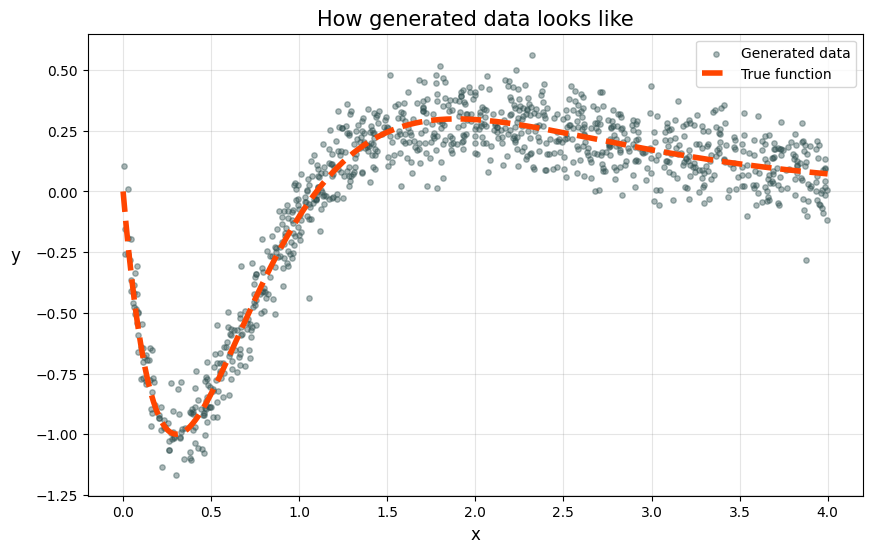

In [26]:
x, y = generate_data()
x_sorted = np.sort(x)
plot_data(x, y, x_sorted)
plt.legend(fontsize=10)

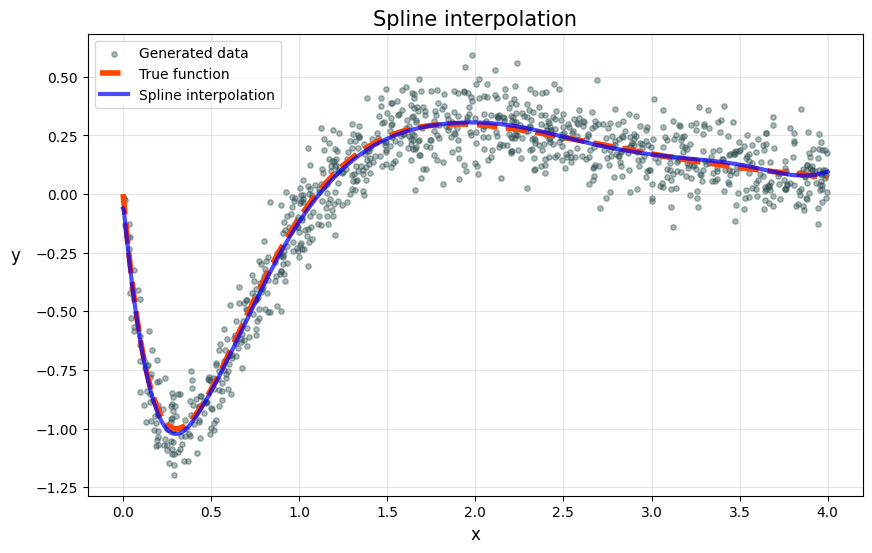

In [27]:
# Generate data
x, y = generate_data(n=1000)
x_sorted = np.sort(x)
x_test = np.linspace(0, 4, 1000).reshape(-1, 1)

# Spline interpolation
spliner = SplineTransformer(n_knots=10, degree=3)
model = make_pipeline(spliner, Ridge(alpha=1e-10))
model.fit(x[:, np.newaxis], y)
spline_predictions = model.predict(x_test)

# Plot
plot_data(x, y, x_sorted, title="Spline interpolation")
plt.plot(
    x_test,
    spline_predictions,
    c="blue",
    label="Spline interpolation",
    linewidth=3,
    alpha=0.7,
)
plt.legend(fontsize=10)

In [23]:
class kernel_regression:
    __slots__ = ["kernel_type", "bandwidth", "x", "y"]

    def __init__(self, kernel_type="gaussian", bandwidth=1):
        self.kernel_type = kernel_type
        self.bandwidth = bandwidth

    def fit(self, x, y):
        self.x = x
        self.y = y

    @abstractmethod
    def gaussian_kernel(self, x, mean, std):
        return np.exp(-0.5 * ((x - mean) / std) ** 2) / (std * np.sqrt(2 * np.pi))

    @abstractmethod
    def top_hat_kernel(self, x, mean, std):
        return (np.abs(x - mean) <= std) / (2 * std)

    @abstractmethod
    def epanechnikov_kernel(self, x, mean, std):
        return 3 / 4 * (1 - ((x - mean) / std) ** 2) * (np.abs(x - mean) <= std) / std

    @abstractmethod
    def exponential_kernel(self, x, mean, std):
        return np.exp(-np.abs(x - mean) / std) / (2 * std)

    def transform(self, x):
        if not isinstance(x, np.ndarray):
            x = np.array([x])
        numerator = np.zeros(len(x))
        denominator = np.zeros(len(x))
        for data_point_x, data_point_y in zip(self.x, self.y):
            if self.kernel_type == "gaussian":
                numerator += (
                    self.gaussian_kernel(x, mean=data_point_x, std=self.bandwidth)
                    * data_point_y
                )
                denominator += self.gaussian_kernel(
                    x, mean=data_point_x, std=self.bandwidth
                )
            elif self.kernel_type == "top_hat":
                numerator += (
                    self.top_hat_kernel(x, mean=data_point_x, std=self.bandwidth)
                    * data_point_y
                )
                denominator += self.top_hat_kernel(
                    x, mean=data_point_x, std=self.bandwidth
                )
            elif self.kernel_type == "epanechnikov":
                numerator += (
                    self.epanechnikov_kernel(x, mean=data_point_x, std=self.bandwidth)
                    * data_point_y
                )
                denominator += self.epanechnikov_kernel(
                    x, mean=data_point_x, std=self.bandwidth
                )
            elif self.kernel_type == "exponential":
                numerator += (
                    self.exponential_kernel(x, mean=data_point_x, std=self.bandwidth)
                    * data_point_y
                )
                denominator += self.exponential_kernel(
                    x, mean=data_point_x, std=self.bandwidth
                )
            else:
                raise ValueError("Invalid kernel type")
        return numerator / denominator

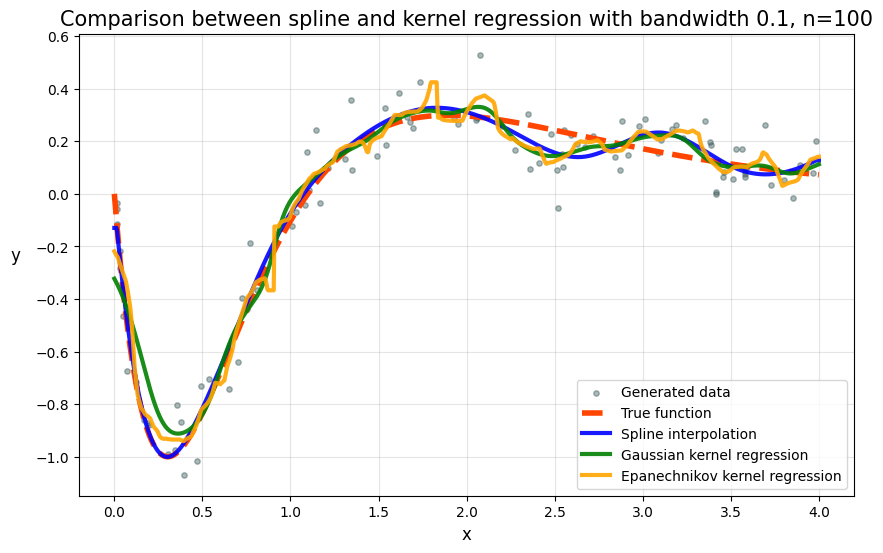

In [51]:
# Generate data
x, y = generate_data(n=100)
x_sorted = np.sort(x)
x_test = np.linspace(0, 4, 1000)

# Spline interpolation
spliner = SplineTransformer(n_knots=10, degree=3)
model = make_pipeline(spliner, Ridge(alpha=1e-10))
model.fit(x[:, np.newaxis], y)
spline_predictions = model.predict(x_test.reshape(-1, 1))

# Kernel regression
kernel_regressor_gauss = kernel_regression(kernel_type="gaussian", bandwidth=0.1)
kernel_regressor_gauss.fit(x, y)
kernel_predictions = kernel_regressor_gauss.transform(x_test)

kernel_regressor_top_hat = kernel_regression(kernel_type="top_hat", bandwidth=0.1)
kernel_regressor_top_hat.fit(x, y)
kernel_predictions_top_hat = kernel_regressor_top_hat.transform(x_test)

kernel_regressor_epanechnikov = kernel_regression(
    kernel_type="epanechnikov", bandwidth=0.1
)
kernel_regressor_epanechnikov.fit(x, y)
kernel_predictions_epanechnikov = kernel_regressor_epanechnikov.transform(x_test)

kernel_regressor_exponential = kernel_regression(
    kernel_type="exponential", bandwidth=0.1
)
kernel_regressor_exponential.fit(x, y)
kernel_predictions_exponential = kernel_regressor_exponential.transform(x_test)

# Plot
plot_data(
    x,
    y,
    x_sorted,
    title="Comparison between spline and kernel regression with bandwidth 0.1, n=100",
)
plt.plot(
    x_test,
    spline_predictions,
    c="blue",
    label="Spline interpolation",
    linewidth=3,
    alpha=0.9,
)
plt.plot(
    x_test,
    kernel_predictions,
    c="green",
    label="Gaussian kernel regression",
    linewidth=3,
    alpha=0.9,
)


plt.plot(
    x_test,
    kernel_predictions_epanechnikov,
    c="orange",
    label="Epanechnikov kernel regression",
    linewidth=3,
    alpha=0.9,
)


plt.legend(fontsize=10)

In [52]:
# calculate the mean squared error for each method
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)


ground_truth = 4.26 * (
    np.exp(-x_test) - 4 * np.exp(-2 * x_test) + 3 * np.exp(-3 * x_test)
)

spline_mse = mean_squared_error(
    ground_truth,
    spline_predictions,
)

kernel_mse = mean_squared_error(
    ground_truth,
    kernel_predictions,
)

kernel_mse_top_hat = mean_squared_error(
    ground_truth,
    kernel_predictions_top_hat,
)

kernel_mse_epanechnikov = mean_squared_error(
    ground_truth,
    kernel_predictions_epanechnikov,
)

kernel_mse_exponential = mean_squared_error(
    ground_truth,
    kernel_predictions_exponential,
)

print("n = 100, bandwidth = 0.1")
print(f"Spline MSE: {spline_mse}")
print(f"Kernel MSE with gaussian: {kernel_mse}")
print(f"Kernel MSE with top hat kernel: {kernel_mse_top_hat}")
print(f"Kernel MSE with epanechnikov kernel: {kernel_mse_epanechnikov}")
print(f"Kernel MSE with exponential kernel: {kernel_mse_exponential}")

n = 100, bandwidth = 0.1
Spline MSE: 0.0014243355676262837
Kernel MSE with gaussian: 0.0035938799811918156
Kernel MSE with top hat kernel: 0.0033431358546914727
Kernel MSE with epanechnikov kernel: 0.003117160787498273
Kernel MSE with exponential kernel: 0.0035447294708543385


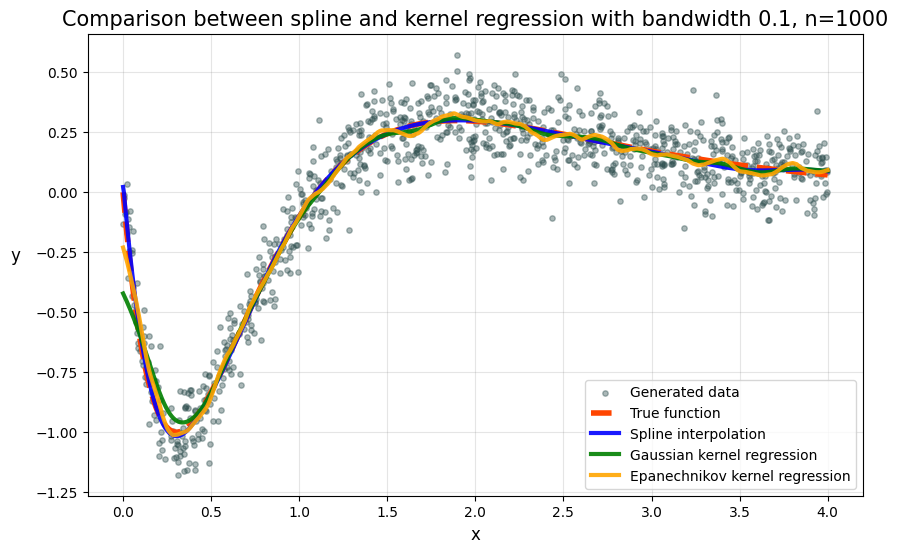

In [59]:
# Generate data
x, y = generate_data(n=1000)
x_sorted = np.sort(x)
x_test = np.linspace(0, 4, 1000)

# Spline interpolation
spliner = SplineTransformer(n_knots=10, degree=3)
model = make_pipeline(spliner, Ridge(alpha=1e-10))
model.fit(x[:, np.newaxis], y)
spline_predictions = model.predict(x_test.reshape(-1, 1))

# Kernel regression
kernel_regressor_gauss = kernel_regression(kernel_type="gaussian", bandwidth=0.1)
kernel_regressor_gauss.fit(x, y)
kernel_predictions = kernel_regressor_gauss.transform(x_test)

kernel_regressor_top_hat = kernel_regression(kernel_type="top_hat", bandwidth=0.1)
kernel_regressor_top_hat.fit(x, y)
kernel_predictions_top_hat = kernel_regressor_top_hat.transform(x_test)

kernel_regressor_epanechnikov = kernel_regression(
    kernel_type="epanechnikov", bandwidth=0.1
)
kernel_regressor_epanechnikov.fit(x, y)
kernel_predictions_epanechnikov = kernel_regressor_epanechnikov.transform(x_test)

kernel_regressor_exponential = kernel_regression(
    kernel_type="exponential", bandwidth=0.1
)
kernel_regressor_exponential.fit(x, y)
kernel_predictions_exponential = kernel_regressor_exponential.transform(x_test)

# Plot
plot_data(
    x,
    y,
    x_sorted,
    title="Comparison between spline and kernel regression with bandwidth 0.1, n=1000",
)
plt.plot(
    x_test,
    spline_predictions,
    c="blue",
    label="Spline interpolation",
    linewidth=3,
    alpha=0.9,
)
plt.plot(
    x_test,
    kernel_predictions,
    c="green",
    label="Gaussian kernel regression",
    linewidth=3,
    alpha=0.9,
)


plt.plot(
    x_test,
    kernel_predictions_epanechnikov,
    c="orange",
    label="Epanechnikov kernel regression",
    linewidth=3,
    alpha=0.9,
)


plt.legend(fontsize=10)

In [56]:
# calculate the mean squared error for each method
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)


ground_truth = 4.26 * (
    np.exp(-x_test) - 4 * np.exp(-2 * x_test) + 3 * np.exp(-3 * x_test)
)

spline_mse = mean_squared_error(
    ground_truth,
    spline_predictions,
)

kernel_mse = mean_squared_error(
    ground_truth,
    kernel_predictions,
)

kernel_mse_top_hat = mean_squared_error(
    ground_truth,
    kernel_predictions_top_hat,
)

kernel_mse_epanechnikov = mean_squared_error(
    ground_truth,
    kernel_predictions_epanechnikov,
)

kernel_mse_exponential = mean_squared_error(
    ground_truth,
    kernel_predictions_exponential,
)

print("n = 1000, bandwidth = 0.1")
print(f"Spline MSE: {spline_mse}")
print(f"Kernel MSE with gaussian: {kernel_mse}")
print(f"Kernel MSE with top hat kernel: {kernel_mse_top_hat}")
print(f"Kernel MSE with epanechnikov kernel: {kernel_mse_epanechnikov}")
print(f"Kernel MSE with exponential kernel: {kernel_mse_exponential}")

n = 1000, bandwidth = 0.1
Spline MSE: 0.00019954461001727957
Kernel MSE with gaussian: 0.0026236218970520256
Kernel MSE with top hat kernel: 0.001561851567984828
Kernel MSE with epanechnikov kernel: 0.0009774933970811068
Kernel MSE with exponential kernel: 0.00304230700682714


In [65]:
# check how the bandwidth affects the kernel regression
bandwidths = np.linspace(0.01, 0.2, 100)
gauss_mses = []
top_hat_mses = []
epanechnikov_mses = []
exponential_mses = []

for bandwidth in bandwidths:

    kernel_regressor_gauss = kernel_regression(
        kernel_type="gaussian", bandwidth=bandwidth
    )
    kernel_regressor_gauss.fit(x, y)
    kernel_predictions = kernel_regressor_gauss.transform(x_test)

    kernel_regressor_top_hat = kernel_regression(
        kernel_type="top_hat", bandwidth=bandwidth
    )
    kernel_regressor_top_hat.fit(x, y)
    kernel_predictions_top_hat = kernel_regressor_top_hat.transform(x_test)

    kernel_regressor_epanechnikov = kernel_regression(
        kernel_type="epanechnikov", bandwidth=bandwidth
    )
    kernel_regressor_epanechnikov.fit(x, y)
    kernel_predictions_epanechnikov = kernel_regressor_epanechnikov.transform(x_test)

    kernel_regressor_exponential = kernel_regression(
        kernel_type="exponential", bandwidth=bandwidth
    )
    kernel_regressor_exponential.fit(x, y)
    kernel_predictions_exponential = kernel_regressor_exponential.transform(x_test)

    gauss_mses.append(
        mean_squared_error(
            ground_truth,
            kernel_predictions,
        )
    )

    top_hat_mses.append(
        mean_squared_error(
            ground_truth,
            kernel_predictions_top_hat,
        )
    )

    epanechnikov_mses.append(
        mean_squared_error(
            ground_truth,
            kernel_predictions_epanechnikov,
        )
    )

    exponential_mses.append(
        mean_squared_error(
            ground_truth,
            kernel_predictions_exponential,
        )
    )

# calculate spline interpolation
spliner = SplineTransformer(n_knots=10, degree=3)
model = make_pipeline(spliner, Ridge(alpha=1e-10))
model.fit(x[:, np.newaxis], y)
spline_predictions = model.predict(x_test.reshape(-1, 1))

/var/folders/g0/c58bxqzn6djcv8sqkxtcj8dc0000gn/T/ipykernel_82090/2736779249.py:68: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


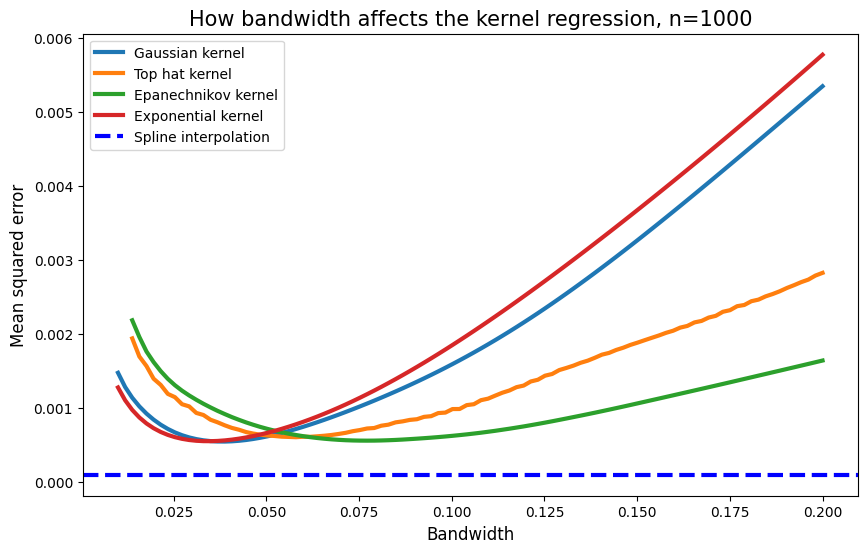

In [66]:
plt.figure(figsize=(10, 6))
plt.plot(bandwidths, gauss_mses, label="Gaussian kernel", linewidth=3)
plt.plot(bandwidths, top_hat_mses, label="Top hat kernel", linewidth=3)
plt.plot(bandwidths, epanechnikov_mses, label="Epanechnikov kernel", linewidth=3)
plt.plot(bandwidths, exponential_mses, label="Exponential kernel", linewidth=3)

# Plot spline interpolation
plt.axhline(
    mean_squared_error(
        ground_truth,
        spline_predictions,
    ),
    c="blue",
    linestyle="--",
    label="Spline interpolation",
    linewidth=3,
)
plt.xlabel("Bandwidth", fontsize=12)
plt.ylabel("Mean squared error", fontsize=12)
plt.title("How bandwidth affects the kernel regression, n=1000", fontsize=15)
plt.legend(fontsize=10)